In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def value(x, y, x_sensor, y_sensor):
    d_sq = (x_sensor-x)**2 + (y_sensor-y)**2
    value = 1/(d_sq + 0.1)
    return value

In [3]:
def earthquake_exercise_setup():
    # explosion detector (using spiral coordinate system)
    # define the coordinate system:
    S = 2000  # number of points on the spiral
    rate = 25  # angular rate of spiral
    sd = 0.2  # standard deviation of the sensor Gaussian noise

    x = np.zeros(S)
    y = np.zeros(S)
    for s in range(1, S + 1):
        theta = rate * 2 * np.pi * s / S
        r = s / S
        x[s - 1] = r * np.cos(theta)
        y[s - 1] = r * np.sin(theta)

    # define the locations of the detection stations on the surface
    # Also define what value on each sensor would be generated by an explosion at internal location s
    N = 30  # number of stations
    x_sensor = np.zeros(N)
    y_sensor = np.zeros(N)
    v = np.zeros((S, N))
    for sensor in range(1, N + 1):
        theta_sensor = 2 * np.pi * sensor / N
        x_sensor[sensor - 1] = np.cos(theta_sensor)
        y_sensor[sensor - 1] = np.sin(theta_sensor)
        for s in range(1, S + 1):
            v[s - 1, sensor - 1] = value(x[s - 1], y[s - 1], x_sensor[sensor - 1], y_sensor[sensor - 1])  # explosion value for some value function

    return x, y, x_sensor, y_sensor, v


In [4]:
x, y, x_sensor, y_sensor, v = earthquake_exercise_setup()

In [5]:
v.shape

(2000, 30)

In [6]:
# read in earthquake files-20231123/EarthquakeExerciseData.txt file
obs = pd.read_csv('earthquake files-20231123/EarthquakeExerciseData.txt', sep='\t', header=None)
obs_array = obs.values.reshape(1, -1)

In [7]:
v.shape

(2000, 30)

In [104]:
def likelihood_H2(v_obs, v_signals, sigma):
    # log likelihood of the observed values given expected signals - log(p(v|s1))
    n = len(v_signals)
    likelihood = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            diff = v_obs - v_signals[i] - v_signals[j]
            likelihood[i, j] = np.prod(np.exp(-0.5 * (diff / sigma)**2) * (1/(sigma * np.sqrt(2*np.pi))))
    
    return likelihood

In [105]:
likelihood = likelihood_H2(v_obs=obs_array, v_signals=v, sigma=0.2)

In [106]:
likelihood

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [110]:
marginal = np.sum(np.sum(likelihood, axis=1), axis=0)

In [111]:
marginal

18715.318905332453

In [113]:
posterior = likelihood/marginal

In [114]:
posterior

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [115]:
max_s1s2 = np.unravel_index(posterior.argmax(), likelihood.shape)

In [116]:
s1 = max_s1s2[0]
s2 = max_s1s2[1]

In [117]:
max_x = x[s1]
max_y = y[s1]
second_max_x = x[s2]
second_max_y = y[s2]

In [118]:
theta_sensor = np.arange(0,2*np.pi,2*np.pi/30)

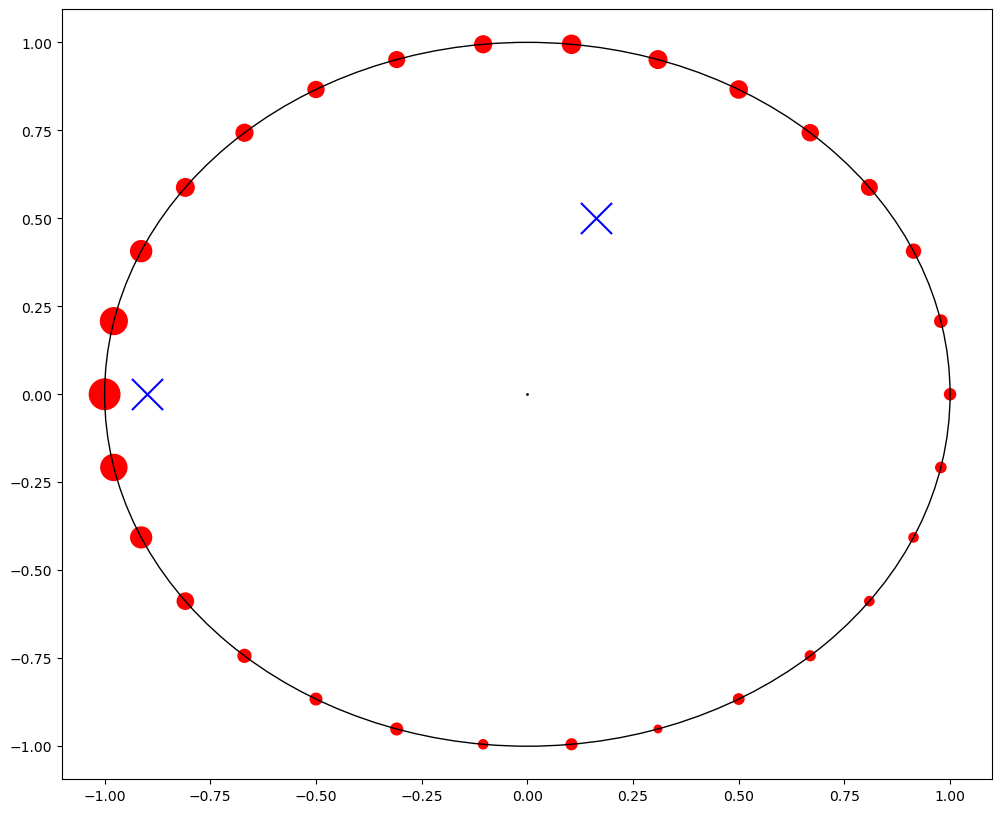

In [121]:
fig = plt.figure(figsize=(12, 10))
# plt.scatter((x,y), c=likelihood, cmap='Greys', s=200, marker='H', vmin=-100, vmax=0)
plt.scatter(x_sensor, y_sensor, c='r', s=obs_array*50)
plt.scatter(0, 0, marker='o', color='k', s=1)
plt.scatter(max_x, max_y, marker='x', c='b', s=500)
plt.scatter(second_max_x, second_max_y, marker='x', c='b', s=500)
circle1 = plt.Circle((0, 0), 1, color='k', fill=False)
ax = plt.gca()
ax.add_artist(circle1)
plt.show()

In [124]:
# log p(v|H2) − log p(v|H1) = log p(v|s2) − log p(v|s1 + s2)
def likelihood_H1(v_obs, v_signals, sigma):
    # log likelihood of the observed values given expected signals - log(p(v|s1))
    n = len(v_signals)
    likelihood = np.zeros((n, 1))
    
    for i in range(n):
            diff = v_obs - v_signals[i]
            likelihood[i] = np.prod(np.exp(-0.5 * (diff / sigma)**2) * (1/(sigma * np.sqrt(2*np.pi))))
    
    return likelihood


In [138]:
likelihood_1 = likelihood_H1(v_obs=obs_array, v_signals=v, sigma=0.2)
log_likelihood_1 = np.log(likelihood_1, where=likelihood_1!=0)

In [139]:
likelihood_2 = likelihood_H2(v_obs=obs_array, v_signals=v, sigma=0.2)
log_likelihood_2 = np.log(likelihood_2, where=likelihood_2!=0)

In [158]:
log_likelihood_2.sum() - log_likelihood_1.sum()

-72562325.30166636